Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 289ms/step - accuracy: 0.1041 - loss: 6.4458 - val_accuracy: 0.0812 - val_loss: 5.6411 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.0968 - loss: 6.3341 - val_accuracy: 0.0969 - val_loss: 5.5736 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.1159 - loss: 6.0396 - val_accuracy: 0.1094 - val_loss: 5.5110 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.1043 - loss: 6.0411 - val_accuracy: 0.1187 - val_loss: 5.4526 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.1171 - loss: 5.9775 - val_accuracy: 0.1375 - val_loss: 5.3980 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.1301 - loss: 5.8402 - val_accuracy: 0.1406 - val_loss: 5.3468 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy

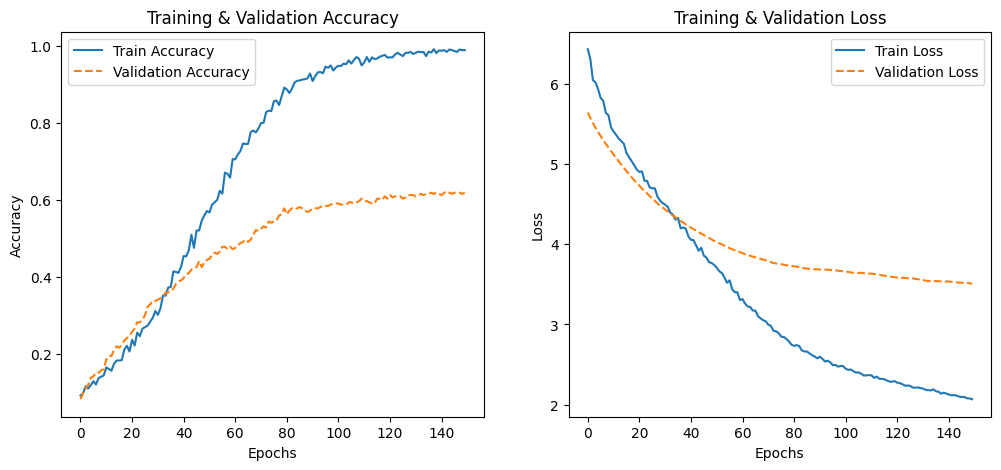

Final Validation Accuracy: 0.6187
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Confusion Matrix:
 [[21  2  0  0  0  0  0  0  7  2]
 [ 2 15  3  1  1  3  1  3  1  2]
 [ 0  0 25  3  0  1  2  1  0  0]
 [ 0  0  1 30  0  0  0  1  0  0]
 [ 1  0  1  0 19  1  1  4  3  2]
 [ 3  0  0  0  0 18  2  3  4  2]
 [ 0  1  2  0  4  2 22  0  0  1]
 [ 2  2  4  0  3  3  4  9  3  2]
 [ 5  0  0  0  1  2  0  0 22  2]
 [ 3  1  0  1  1  2  1  0  6 17]]

Classification Report:
               precision    recall  f1-score   support

           0     0.5676    0.6562    0.6087        32
           1     0.7143    0.4688    0.5660        32
           2     0.6944    0.7812    0.7353        32
           3     0.8571    0.9375    0.8955        32
           4     0.6552    0.5938    0.6230        32
           5     0.5625    0.5625    0.5625        32
           6     0.6667    0.6875    0.6769        32
           7     0.4286    0.2812    0.3396        32
           8     0.4783    0.6875    0.5641        32
          

Model weights saved as: inverted_alexnet_pca_rnn.weights.h5
Model saved at: saved_model\inverted_alexnet_pca.h5


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "inverted_alexnet_pca"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.0957 - loss: 5.0597 - val_accuracy: 0.1187 - val_loss: 4.2265 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0931 - loss: 5.0263 - val_accuracy: 0.1063 - val_loss: 4.1949 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1004 - loss: 4.9108 - val_accuracy: 0.1031 - val_loss: 4.1654 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0923 - loss: 4.8362 - val_accuracy: 0.1063 - val_loss: 4.1378 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1195 - loss: 4.7571 - val_accuracy: 0.1000 - val_loss: 4.1122 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0871 - loss: 4.7576 - val_accuracy: 0.1000 - val_loss: 4.0885 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy

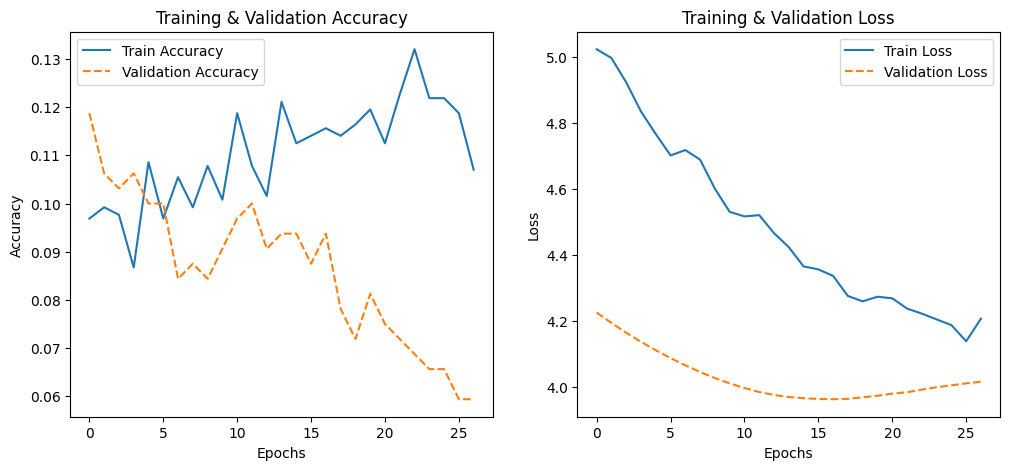

Final Validation Accuracy: 0.0938
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  

Confusion Matrix:
 [[1 1 5 2 4 7 1 3 7 1]
 [3 0 4 7 5 5 1 4 2 1]
 [2 1 5 1 4 4 3 5 4 3]
 [6 0 6 8 3 3 0 2 1 3]
 [1 1 2 4 5 5 6 2 2 4]
 [5 2 2 2 9 3 0 2 5 2]
 [1 1 2 4 5 3 3 3 4 6]
 [0 2 3 2 5 8 3 2 4 3]
 [3 1 6 4 6 5 2 2 1 2]
 [4 0 5 5 5 2 3 4 2 2]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0385    0.0312    0.0345        32
           1     0.0000    0.0000    0.0000        32
           2     0.1250    0.1562    0.1389        32
           3     0.2051    0.2500    0.2254        32
           4     0.0980    0.1562    0.1205        32
           5     0.0667    0.0938    0.0779        32
           6     0.1364    0.0938    0.1111        32
           7     0.0690    0.0625    0.0656        32
           8     0.0312    0.0312    0.0312        32
           9     0.0741    0.0625    0.0678        32

    accuracy                         0.0938       320


Model saved at: saved_model\inverted_alexnet_lda.h5


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_alexnet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "inverted_alexnet_lda"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.1128 - loss: 6.3259 - val_accuracy: 0.1187 - val_loss: 5.6388 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.1022 - loss: 6.2796 - val_accuracy: 0.1344 - val_loss: 5.5699 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1108 - loss: 6.1397 - val_accuracy: 0.1500 - val_loss: 5.5053 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.1156 - loss: 6.0215 - val_accuracy: 0.1625 - val_loss: 5.4441 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1337 - loss: 5.9120 - val_accuracy: 0.1781 - val_loss: 5.3856 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1373 - loss: 5.7799 - val_accuracy: 0.2000 - val_loss: 5.3291 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy

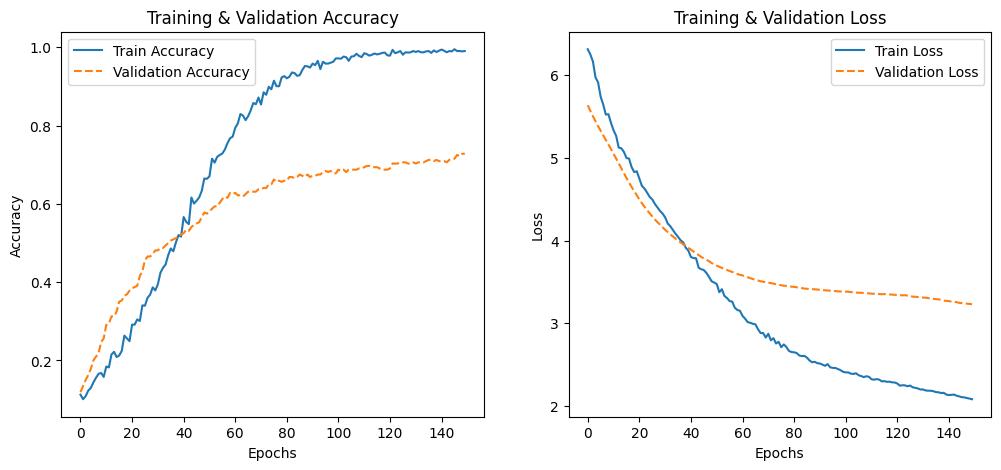

Final Validation Accuracy: 0.7281
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Confusion Matrix:
 [[25  0  0  0  0  0  0  1  2  4]
 [ 1 22  3  0  0  0  0  0  2  4]
 [ 0  2 21  1  3  0  3  2  0  0]
 [ 0  0  1 28  0  0  1  2  0  0]
 [ 0  0  0  1 21  4  1  3  0  2]
 [ 0  3  1  0  1 21  0  4  0  2]
 [ 0  0  0  1  2  0 28  1  0  0]
 [ 0  5  0  1  3  1  0 16  0  6]
 [ 2  1  0  0  0  0  0  0 29  0]
 [ 2  1  0  0  1  0  0  2  4 22]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8333    0.7812    0.8065        32
           1     0.6471    0.6875    0.6667        32
           2     0.8077    0.6562    0.7241        32
           3     0.8750    0.8750    0.8750        32
           4     0.6774    0.6562    0.6667        32
           5     0.8077    0.6562    0.7241        32
           6     0.8485    0.8750    0.8615        32
           7     0.5161    0.5000    0.5079        32
           8     0.7838    0.9062    0.8406        32
          

Model weights saved as: inverted_googlenet_pca_rnn.weights.h5
Model saved at: saved_model\inverted_googlenet_pca.h5


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "inverted_googlenet_pca"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.0959 - loss: 5.1836 - val_accuracy: 0.0812 - val_loss: 4.2309 - learning_rate: 1.0000e-04
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0991 - loss: 5.1862 - val_accuracy: 0.0938 - val_loss: 4.1994 - learning_rate: 1.0000e-04
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1072 - loss: 4.9803 - val_accuracy: 0.1000 - val_loss: 4.1700 - learning_rate: 1.0000e-04
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1003 - loss: 4.9299 - val_accuracy: 0.0969 - val_loss: 4.1426 - learning_rate: 1.0000e-04
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0979 - loss: 4.9281 - val_accuracy: 0.0938 - val_loss: 4.1171 - learning_rate: 1.0000e-04
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1141 - loss: 4.8277 - val_accuracy: 0.0938 - val_loss: 4.0934 - learning_rate: 1.0000e-04
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy:

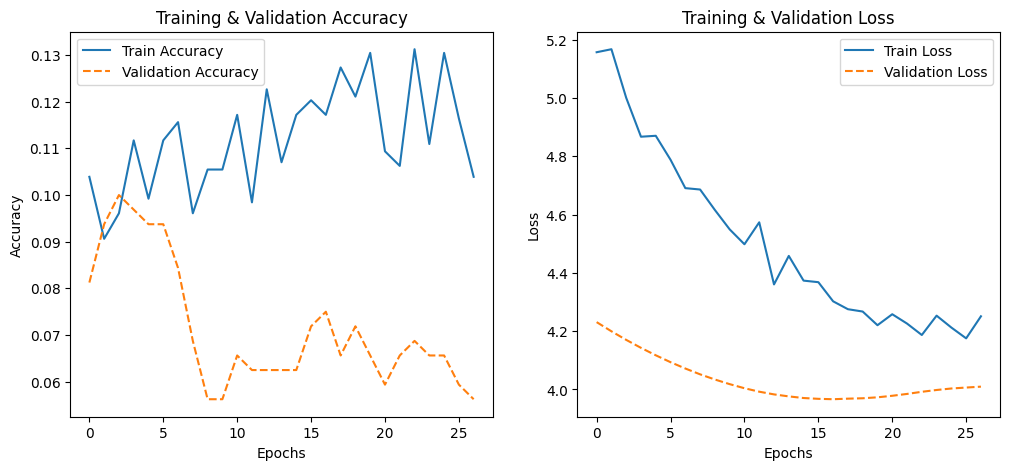

Final Validation Accuracy: 0.0750
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  



Confusion Matrix:
 [[2 5 1 9 3 2 2 2 2 4]
 [6 4 3 2 3 4 2 6 1 1]
 [7 7 4 0 5 2 1 1 3 2]
 [3 5 4 0 1 6 3 1 7 2]
 [2 6 7 1 2 5 1 4 1 3]
 [5 7 3 2 6 3 0 2 2 2]
 [4 5 4 5 4 3 0 2 3 2]
 [5 1 6 3 1 5 1 5 2 3]
 [4 2 5 3 6 1 2 3 3 3]
 [7 1 5 2 6 3 1 4 2 1]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0444    0.0625    0.0519        32
           1     0.0930    0.1250    0.1067        32
           2     0.0952    0.1250    0.1081        32
           3     0.0000    0.0000    0.0000        32
           4     0.0541    0.0625    0.0580        32
           5     0.0882    0.0938    0.0909        32
           6     0.0000    0.0000    0.0000        32
           7     0.1667    0.1562    0.1613        32
           8     0.1154    0.0938    0.1034        32
           9     0.0435    0.0312    0.0364        32

    accuracy                         0.0750       320
   macro avg     0.0701    0.0750    0.0717       320
weighted avg     0.0

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\inverted_googlenet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "inverted_googlenet_lda"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.0988 - loss: 6.8650 - val_accuracy: 0.1297 - val_loss: 5.8609 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.1106 - loss: 6.3847 - val_accuracy: 0.1641 - val_loss: 5.6233 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.1145 - loss: 6.0364 - val_accuracy: 0.1813 - val_loss: 5.4339 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.1393 - loss: 5.8250 - val_accuracy: 0.1984 - val_loss: 5.2766 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.1331 - loss: 5.6613 - val_accuracy: 0.2289 - val_loss: 5.1570 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.1557 - loss: 5.4994 - val_accuracy: 0.2406 - val_loss: 5.0690 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy

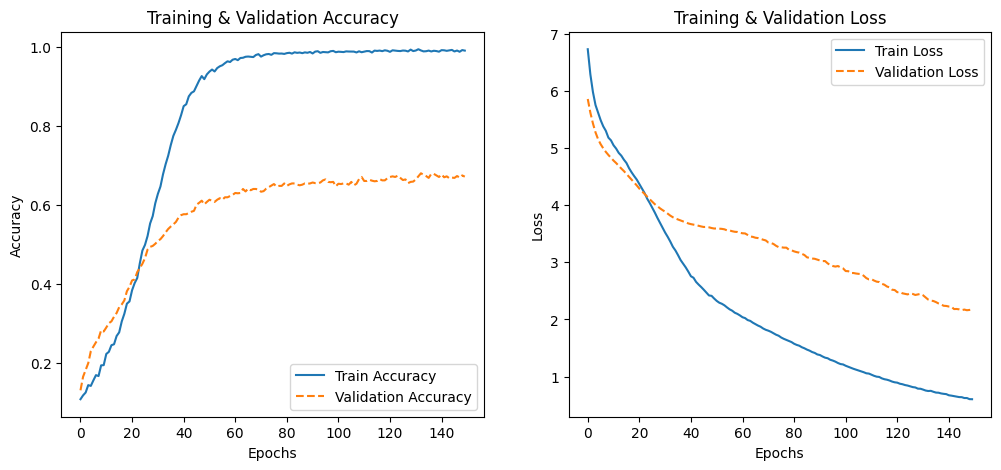

Final Validation Accuracy: 0.6695
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Confusion Matrix:
 [[ 83   7   0   1   1   5   1  10   8  12]
 [  8  60  16   7   8   4   3  12   5   5]
 [  0   2 107  10   0   1   3   2   2   1]
 [  0   5  13 101   4   2   1   2   0   0]
 [  0   1   4   1  98   5   3  13   2   1]
 [  3   5   1   2   8  70  15   6   4  14]
 [  0   0   4   3  11   7 100   1   1   1]
 [ 17   6   4   5  10  11   3  63   4   5]
 [ 19   4   1   0   3   1   1   0  92   7]
 [ 15   3   0   1   0   4   5   6  11  83]]

Classification Report:
               precision    recall  f1-score   support

           0     0.5724    0.6484    0.6081       128
           1     0.6452    0.4688    0.5430       128
           2     0.7133    0.8359    0.7698       128
           3     0.7710    0.7891    0.7799       128
           4     0.6853    0.7656    0.7232       128
           5     0.6364    0.5469    0.5882       128
           6     0.7407    0.7812    0.7605       128
           7     0

Model weights saved as: multi_augmented_alexnet_pca_rnn.weights.h5
Model saved at: saved_model\multi_augmented_alexnet_pca.h5


In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "multi_augmented_alexnet_pca"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.0983 - loss: 4.9173 - val_accuracy: 0.0977 - val_loss: 4.1383 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.1089 - loss: 4.7068 - val_accuracy: 0.1016 - val_loss: 4.0442 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1170 - loss: 4.5216 - val_accuracy: 0.1094 - val_loss: 3.9742 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1099 - loss: 4.4667 - val_accuracy: 0.1086 - val_loss: 3.9276 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1065 - loss: 4.3631 - val_accuracy: 0.1086 - val_loss: 3.9008 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1150 - loss: 4.2805 - val_accuracy: 0.1133 - val_loss: 3.8831 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy:

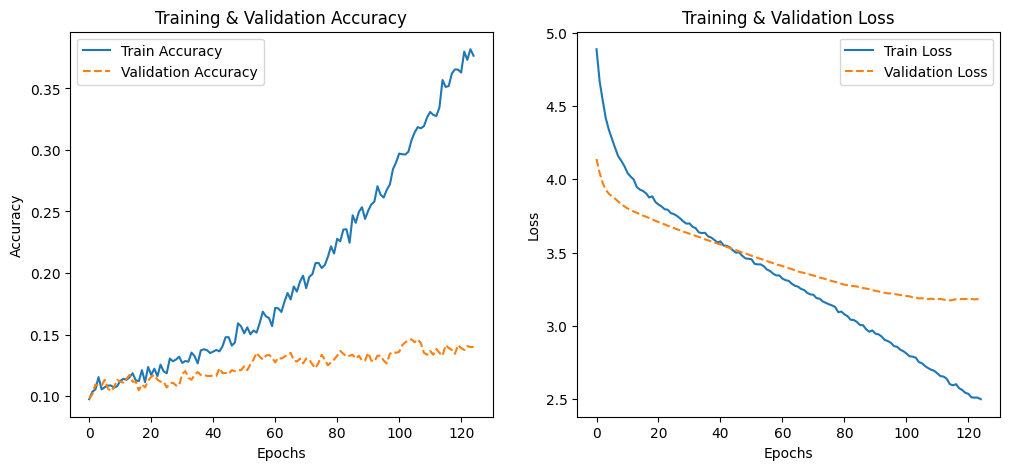

Final Validation Accuracy: 0.1328
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Confusion Matrix:
 [[ 4 14  9 13 14 16 11 14 13 20]
 [12 18  8  8 22 10  8 12 15 15]
 [12  7 12 16 21 17  9 16  6 12]
 [12 13  8 23 14 14 14 12  9  9]
 [ 6 16  4 11 20  9 16 14 15 17]
 [15 12  7 11  8 13 12 18 15 17]
 [ 8 13  8 19  9  7 25 10 14 15]
 [10 15 15  8 15  9  9 24 12 11]
 [10  8  9 11 19 10 10 22 15 14]
 [12 13  6  9  7 17 11 22 15 16]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0396    0.0312    0.0349       128
           1     0.1395    0.1406    0.1401       128
           2     0.1395    0.0938    0.1121       128
           3     0.1783    0.1797    0.1790       128
           4     0.1342    0.1562    0.1444       128
           5     0.1066    0.1016    0.1040       128
           6     0.2000    0.1953    0.1976       128
           7     0.1463    0.1875    0.1644       128
           8     0.1163    0.1172    0.1167       128
          

Model weights saved as: multi_augmented_alexnet_lda_rnn.weights.h5
Model saved at: saved_model\multi_augmented_alexnet_lda.h5


In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_alexnet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "multi_augmented_alexnet_lda"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.1025 - loss: 7.1424 - val_accuracy: 0.2180 - val_loss: 6.1361 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.1392 - loss: 6.4830 - val_accuracy: 0.2906 - val_loss: 5.8247 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.1688 - loss: 6.0951 - val_accuracy: 0.3328 - val_loss: 5.5219 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.2084 - loss: 5.7921 - val_accuracy: 0.3766 - val_loss: 5.2324 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.2356 - loss: 5.5251 - val_accuracy: 0.4000 - val_loss: 5.0037 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.2647 - loss: 5.3616 - val_accuracy: 0.4273 - val_loss: 4.8481 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - ac

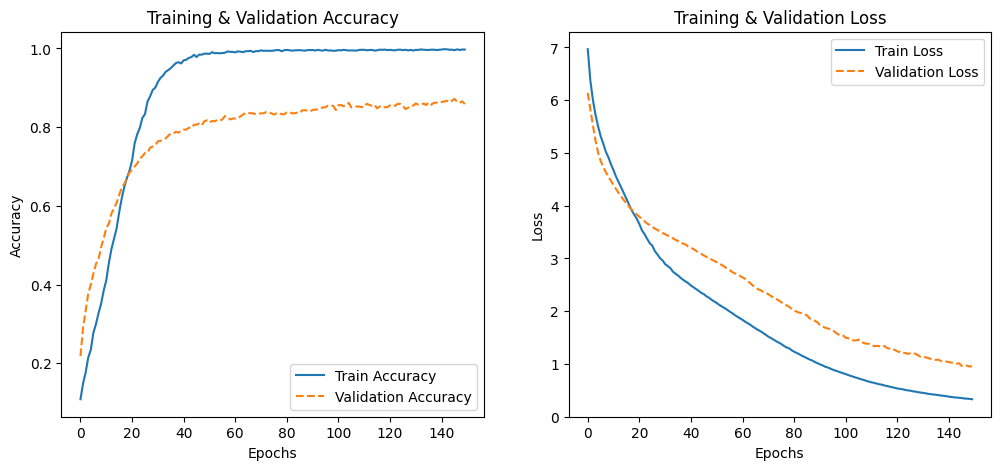

Final Validation Accuracy: 0.8656
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Confusion Matrix:
 [[112   4   0   0   0   1   0   3   3   5]
 [  2 104   5   1   3   1   0   5   6   1]
 [  0   9 106   5   2   0   2   3   1   0]
 [  0   4   1 115   2   1   4   0   0   1]
 [  0   2   3   0 110   3   2   5   1   2]
 [  0   2   2   1   5 109   0   7   0   2]
 [  0   1   0   1   0   0 124   0   0   2]
 [  2  15   1   2  10   7   0  91   0   0]
 [  4   1   0   0   0   0   0   1 120   2]
 [  5   0   0   0   0   2   2   0   2 117]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8960    0.8750    0.8854       128
           1     0.7324    0.8125    0.7704       128
           2     0.8983    0.8281    0.8618       128
           3     0.9200    0.8984    0.9091       128
           4     0.8333    0.8594    0.8462       128
           5     0.8790    0.8516    0.8651       128
           6     0.9254    0.9688    0.9466       128
           7     

Model weights saved as: multi_augmented_googlenet_pca_rnn.weights.h5
Model saved at: saved_model\multi_augmented_googlenet_pca.h5


In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_pca.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_pca_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "multi_augmented_googlenet_pca"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")



Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.1097 - loss: 4.9456 - val_accuracy: 0.0992 - val_loss: 4.1358 - learning_rate: 1.0000e-04
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.1037 - loss: 4.7140 - val_accuracy: 0.1102 - val_loss: 4.0428 - learning_rate: 1.0000e-04
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0989 - loss: 4.6032 - val_accuracy: 0.1023 - val_loss: 3.9752 - learning_rate: 1.0000e-04
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.0994 - loss: 4.4689 - val_accuracy: 0.1000 - val_loss: 3.9342 - learning_rate: 1.0000e-04
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.1097 - loss: 4.3527 - val_accuracy: 0.0922 - val_loss: 3.9124 - learning_rate: 1.0000e-04
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.1181 - loss: 4.2917 - val_accuracy: 0.0922 - val_loss: 3.8979 - learning_rate: 1.0000e-04
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy

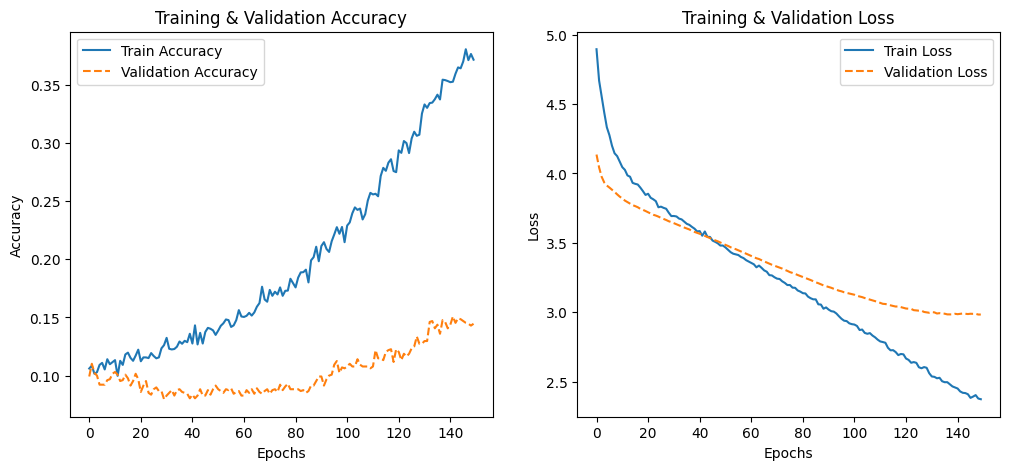

Final Validation Accuracy: 0.1445
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Confusion Matrix:
 [[11 11  9  8 17 18  7 11 16 20]
 [15 26  7 10  5 20 11 16 11  7]
 [10 12 10  9 10 13 10 20 16 18]
 [ 7 12  8 34 10 16 12 12  7 10]
 [ 8 14  3 13  7 16 17 20 14 16]
 [19 20  6 12 10 16 11 12 12 10]
 [ 6 15  8 15  8  9 30 15  9 13]
 [12 14  8 11  5 11 15 25 17 10]
 [19 14 10 14  9 16  6 14  8 18]
 [11 16 15  9 12 10  9 14 14 18]]

Classification Report:
               precision    recall  f1-score   support

           0     0.0932    0.0859    0.0894       128
           1     0.1688    0.2031    0.1844       128
           2     0.1190    0.0781    0.0943       128
           3     0.2519    0.2656    0.2586       128
           4     0.0753    0.0547    0.0633       128
           5     0.1103    0.1250    0.1172       128
           6     0.2344    0.2344    0.2344       128
           7     0.1572    0.1953    0.1742       128
           8     0.0645    0.0625    0.0635       128
          

Model weights saved as: multi_augmented_googlenet_lda_rnn.weights.h5
Model saved at: saved_model\multi_augmented_googlenet_lda.h5


In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Load preprocessed feature data
X = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_lda.npy")
y = np.load(r"D:\project work 2 phase 2\fingerprint\reduced_features\multi_augmented_googlenet_lda_labels.npy")

# Ensure y has two labels (FingerIndex and UserID)
if y.ndim == 3:
    y = np.argmax(y, axis=-1)  # Convert one-hot encoding to categorical labels if needed

if y.ndim == 1:
    raise ValueError("Expected y to have two labels (FingerIndex and UserID), but got a 1D array.")

# Extract FingerIndex labels only
finger_index_labels = y[:, 0]  # First column for FingerIndex

# Convert labels to categorical encoding
num_classes_finger = len(np.unique(finger_index_labels))
y_finger = to_categorical(finger_index_labels, num_classes_finger)

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_finger_train, y_finger_val = train_test_split(
    X, y_finger, test_size=0.2, random_state=42, stratify=finger_index_labels
)

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define input layer
input_layer = Input(shape=(1, X_train.shape[2]))

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

finger_output = Dense(num_classes_finger, activation='softmax', name='finger_output')(x)

# Define the model
model = Model(inputs=input_layer, outputs=finger_output)

# Compile model
optimizer = AdamW(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train model
history = model.fit(
    X_train, y_finger_train,
    validation_data=(X_val, y_finger_val),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], linestyle='dashed', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_finger_val, verbose=0)

# Print Validation Accuracy at the End
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_finger_val, axis=1)

# Compute performance metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_report = classification_report(y_true_classes, y_pred_classes, digits=4)

# Print Confusion Matrix and Classification Report
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save Model in a Separate Folder
model_dir = "saved_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save model weights with the correct filename format
model_name = "multi_augmented_googlenet_lda"  # Change this to the new model name
model_filename = f"{model_name}_rnn.weights.h5"  # Corrected extension

# Save the model weights
model.save_weights(os.path.join(model_dir, model_filename))
print(f"Model weights saved as: {model_filename}")

# Save entire model
model_path = os.path.join(model_dir, f"{model_name}.h5")
model.save(model_path)
print(f"Model saved at: {model_path}")

